# Validation plots

In [1]:
import os
import pickle

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import baryon_painter.utils.datasets as datasets
import baryon_painter.painter
import baryon_painter.utils.validation_plotting as validation_plotting

In [2]:
machine = "laptop"

if machine == "laptop":
    data_path = "../data/training_data/BAHAMAS/stacks_uncompressed_new/"
    output_path = "../data/checkpoints/"
    compute_device = "cpu"
    
elif machine == "arrakis":
    data_path = "../../painting_baryons/training_data/BAHAMAS/stacks_new/"
    output_path = "../output/"
    compute_device = "cuda:0"


In [8]:
with open(os.path.join(data_path, "train_files_info.pickle"), "rb") as f:
    training_files_info = pickle.load(f)

n_training_stack = 11
n_validation_stack = 3
 
n_scale = 1
n_aux_label = 1
label_fields = ["pressure"]
redshifts = [0.0, 0.125, 0.25, 0.375, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]

validation_dataset = datasets.BAHAMASDataset(files=training_files_info, root_path=data_path,
                                             redshifts=redshifts,
                                             label_fields=label_fields,
                                             n_stack=n_validation_stack, stack_offset=n_training_stack,
                                             n_feature_per_field=n_scale,
                                             mmap_mode="r",
                                             scale_to_SLICS=True,
                                            )

In [224]:
model_path = "../trained_models/CVAE/fiducial/"

painter = baryon_painter.painter.CVAEPainter((os.path.join(model_path, "model_state"),
                                              os.path.join(model_path, "model_meta")), 
                                             compute_device=compute_device)


CVAE with Type-1 architecture.


Plot one sample each for four redshifts

Redshift z=0.0
Redshift z=1.0


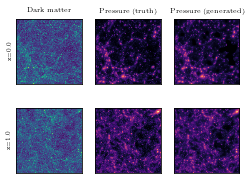

In [246]:
validation_redshifts = [0.0, 1.0]

fig, ax = plt.subplots(len(validation_redshifts), 3, figsize=(4, 1.5*len(validation_redshifts)))

for i, z in enumerate(validation_redshifts):
    print(f"Redshift z={z}")
    
    # Get samples from the test set
    samples, idx, redshifts = validation_dataset.get_batch(size=1, z=z)

    dm = samples[0,0]
    pressure_truth = samples[1,0]
    
    # Paint the pressure tile!
    pressure_fake = painter.paint(dm, z=redshifts[0], transform=True, inverse_transform=True)
    
    ax[i,0].imshow(np.log(dm/dm.std()+0.02))
    ax[i,1].imshow(np.log(pressure_truth/pressure_truth.std()+0.02), cmap="magma")
    ax[i,2].imshow(np.log(pressure_fake/pressure_fake.std()+0.02), cmap="magma")
    
    ax[i,0].set_ylabel(f"z={z:.1f}")
    
ax[0,0].set_title("Dark matter")
ax[0,1].set_title("Pressure (truth)")
ax[0,2].set_title("Pressure (generated)")

for p in ax.flat:
    p.set_xticks([])
    p.set_yticks([])

fig.savefig("./plots/samples_z0.0_z1.0.png", dpi=300)

Plot some cross-power spectra!

In [ ]:
n_sample = 16
validation_redshifts = [0.0, 0.5, 1.0, 2.0,]

for z in validation_redshifts:
    print(f"Redshift z={z}")
    samples, idx, redshifts = validation_dataset.get_batch(size=n_sample, z=z)

    dm = []
    pressure_truth = []
    pressure_fake = []
    for i in range(n_sample):
        in_ = samples[0,i]
        truth = samples[1,i]        
        out = painter.paint(in_, z=redshifts[i], transform=True, inverse_transform=True)
        
        dm.append(in_)
        pressure_truth.append(truth)
        pressure_fake.append(out)

        
    dm = np.array(dm)
    pressure_truth = np.array(pressure_truth)
    pressure_fake = np.array(pressure_fake)
    
    fig, ax = validation_plotting.plot_power_spectra(output_true=pressure_truth[:,None,...], 
                                                           input=dm[:,None,...], 
                                                           output_pred=pressure_fake[:,None,...],
                                                           L=validation_dataset.tile_L,
                                                           output_labels=validation_dataset.label_fields,
                                                           mode="cross",
                                                           n_feature_per_field=validation_dataset.n_feature_per_field,
                                                           plot_size=(5,2))
        
    fig.suptitle(f"Cross power spectrum z={z if z is not None else 'all'}")
    
    fig, ax = validation_plotting.plot_histogram(output_true=pressure_truth[:,None,...], 
                                                 output_pred=pressure_fake[:,None,...], 
                                                 n_sample=4, 
                                                 labels=validation_dataset.label_fields, 
                                                 plot_size=(4,2), 
                                                 y_logscale=True, x_logscale=True,
                                                 histtype="step")
    fig.suptitle(f"Pressure histogram z={z if z is not None else 'all'}")
                 
    
    
    

# Paper plots

## PainterCVAE

In [129]:
run_name = "single_scale_max_z2_res4_prior_late_prelu_log_shift_softmax_lr1e-3_fast_decay2"

painter["CVAE_fid"] = baryon_painter.painter.CVAEPainter((os.path.join(output_path, run_name, "model_state"),
                                              os.path.join(output_path, run_name, "model_meta")), 
                                             compute_device=compute_device)

run_name = "single_scale_max_z2_res4_prior_late_prelu_log_shift_softmax_lr1e-3_fast_decay3"

painter["CVAE_fid2"] = baryon_painter.painter.CVAEPainter((os.path.join(output_path, run_name, "model_state"),
                                              os.path.join(output_path, run_name, "model_meta")), 
                                             compute_device=compute_device)

run_name = "single_scale_max_z2_no_z0.25_res4_prior_late_prelu_log_shift_softmax_lr1e-3_fast_decay"

painter["CVAE_fid_no_z0.25"] = baryon_painter.painter.CVAEPainter((os.path.join(output_path, run_name, "model_state"),
                                              os.path.join(output_path, run_name, "model_meta")), 
                                             compute_device=compute_device)


CVAE with Type-1 architecture.
CVAE with Type-1 architecture.
CVAE with Type-1 architecture.


# PainterGAN

In [133]:
import sys
import importlib
sys.path.append("../PainterGAN/painter-src/")
import src.tools.template
importlib.reload(src.tools.template)

parts_folder = "../PainterGAN/e85/"
checkpoint = "g_85_95_iter.cp"

painter["GAN_fid"] = src.tools.template.GAN_Painter(parts_folder, 
                         checkpoint_file=checkpoint,
                         device="cpu")

parts_folder = "../PainterGAN/missing_25_e100/"
checkpoint = "g_100_95_iter.cp"

painter["GAN_fid_no_z0.25"] = src.tools.template.GAN_Painter(parts_folder, 
                         checkpoint_file=checkpoint,
                         device="cpu")

Creating...
 -> ResNet Translator
Creating...
 -> ResNet Translator


In [200]:
n_sample = 64

dm_z = {}
pressure_truth_z = {}
pressure_fake_z = {}

In [201]:
redshifts = [0.0, 0.5, 1.0, 2.0,]
# redshifts = [0.25]

for model in ["CVAE_fid",
              #"CVAE_fid2",
#               "CVAE_fid_no_z0.25",
              "GAN_fid",
#               "GAN_fid_no_z0.25",
             ]:

    print(f"Model {model}")
    if model not in dm_z: dm_z[model] = {}
    if model not in pressure_truth_z: pressure_truth_z[model] = {}
    if model not in pressure_fake_z: pressure_fake_z[model] = {}

    np.random.seed(34624)
    for z in redshifts:
        print(f"Redshift z={z}")
        samples, idx, sample_redshifts = validation_dataset.get_batch(size=n_sample, z=z)

        dm = []
        pressure_truth = []
        pressure_fake = []
        for i in range(n_sample):
            in_ = samples[0,i]
            truth = samples[1,i]        
            out = painter[model].paint(in_, z=sample_redshifts[i], transform=True, inverse_transform=True)

            dm.append(in_)
            pressure_truth.append(truth)
            pressure_fake.append(out)


        dm_z[model][z] = np.array(dm)
        pressure_truth_z[model][z] = np.array(pressure_truth)
        pressure_fake_z[model][z] = np.array(pressure_fake)


Model CVAE_fid
Redshift z=0.0
Redshift z=0.5
Redshift z=1.0
Redshift z=2.0
Model GAN_fid
Redshift z=0.0
Redshift z=0.5
Redshift z=1.0
Redshift z=2.0


In [202]:
Pk = {}

L = 100.0
k_min = 2*pi/L
k_max = 2*pi/L*512/2

n_k_bin = 20
logspaced_k_bins = True

for model in ["truth",
              "CVAE_fid", 
              "GAN_fid",
             ]:
    print(f"Model {model}")
    if model not in Pk: Pk[model] = {}
    for z in redshifts:
        print(f"  z : {z}")
        if z not in Pk[model]: 
            Pk[model][z] = {"auto" : np.zeros((n_sample, n_k_bin)),
                            "cross" : np.zeros((n_sample, n_k_bin))}
        for i in range(n_sample):
            if model == "truth":
                d = dm_z["CVAE_fid"][z][i]
                p = pressure_truth_z["CVAE_fid"][z][i]
            else:
                d = dm_z[model][z][i]
                p = pressure_fake_z[model][z][i]
                
            Pk[model][z]["auto"][i], k, Pk_var_true, n_mode = cosmotools.power_spectrum_tools.pseudo_Pofk(
                                        p, p, 
                                        L, k_min=k_min, k_max=k_max, n_k_bin=n_k_bin, 
                                        logspaced_k_bins=logspaced_k_bins)
            Pk[model][z]["cross"][i], k, Pk_var_true, n_mode = cosmotools.power_spectrum_tools.pseudo_Pofk(
                                        d, p, 
                                        L, k_min=k_min, k_max=k_max, n_k_bin=n_k_bin, 
                                        logspaced_k_bins=logspaced_k_bins)


Model truth
  z : 0.0
  z : 0.5
  z : 1.0
  z : 2.0
Model CVAE_fid
  z : 0.0
  z : 0.5
  z : 1.0
  z : 2.0
Model GAN_fid
  z : 0.0
  z : 0.5
  z : 1.0
  z : 2.0


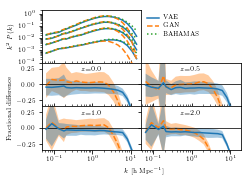

In [223]:
import matplotlib.gridspec

import cosmotools.power_spectrum_tools
import cosmotools.plotting

pi = np.pi

import matplotlib
matplotlib.rc("font", size=6)
matplotlib.rc("font", family="serif")

matplotlib.rc("text", usetex=True)

n_row = 3
n_col = 2
column_width = 240.0/72

fig, ax = plt.subplots(n_row, n_col, sharex=False, figsize=(column_width, column_width*0.7),
                       gridspec_kw={"height_ratios" : [1.2, 1, 1]})
fig.subplots_adjust(left=0.15, bottom=0.15, top=0.98, right=0.98, hspace=0, wspace=0)

ax_Pk = ax[0,0]

model2color = {"CVAE_fid" : "C0",
               "GAN_fid" : "C1",
               "truth" : "C2"}
model2label = {"CVAE_fid" : "VAE",
               "GAN_fid" : "GAN",
               "truth" : "BAHAMAS"}
model2ls = {"CVAE_fid"      : "-",
            "GAN_fid"      : "--",
            "truth" : ":",}
plot_redshifts = [0.0, 0.5, 1.0, 2.0]

redshift2ax = {0.0 : (1, 0),
               0.5 : (1, 1),
               1.0 : (2, 0),
               2.0 : (2, 1)}

for model in ["CVAE_fid", 
              "GAN_fid",
              "truth"
             ]:
    ax_Pk.plot([], [], c=model2color[model], ls=model2ls[model], label=model2label[model])
    for z in plot_redshifts:            
        mean = Pk[model][z]["cross"].mean(axis=0)
        mean[mean <=0] = np.nan
        ax_Pk.loglog(k, k**2*mean, ls=model2ls[model], c=model2color[model])
    
ax[0,1].axis("off")
ax_Pk.legend(loc=2, frameon=False, ncol=1, bbox_to_anchor=(1,1))
# ax_Pk.set_xlabel("$k$ [h Mpc$^{-1}$]")
ax_Pk.set_ylabel("$k^2\ P(k)$")
ax_Pk.set_ylim(1e-4, 2.0e0)

ax_Pk.tick_params(axis="x", which="both", direction="in")

for model in ["GAN_fid",
              "CVAE_fid", 
             ]:
    for z in plot_redshifts:            
        idx = redshift2ax[z]
        ax[idx].axhline(0, c="k", lw=0.5)

        ratio = Pk[model][z]["cross"]/Pk["truth"][z]["cross"] - 1
        ratio_std = ratio.std(axis=0, ddof=1)
        ratio_mean = ratio.mean(axis=0)
        
        ax[idx].fill_between(k, ratio_mean-ratio_std, ratio_mean+ratio_std,
                             facecolor=model2color[model], alpha=0.4)
        ax[idx].plot(k, ratio_mean, c=model2color[model], ls=model2ls[model],
                     label=model2label[model])
        
        ax[idx].set_xscale("log")
        ax[idx].set_ylim(-0.35, 0.35)
        ax[idx].set_title(f"$z$={z:.1f}", pad=-8)
        
        if idx[1] > 0:
            ax[idx].set_yticklabels([])
        if idx[0] == 1:
            ax[idx].tick_params(axis="x", which="both", direction="in")
    


fig.text(0.01, 0.40, "Fractional difference", va='center', rotation='vertical')
fig.text(0.58, 0.01, "$k$ [h Mpc$^{-1}$]", ha='center')

    
fig.savefig("../paper/overleaf/figures/tile_power_spectra_deviation_fid.pdf")

